In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from PIL import ImageDraw

In [2]:
cv.__version__

'3.4.11'

In [3]:
voc_set = datasets.VOCDetection('../../data/', download=False)

In [4]:
image, label = voc_set[0]

In [5]:
label

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

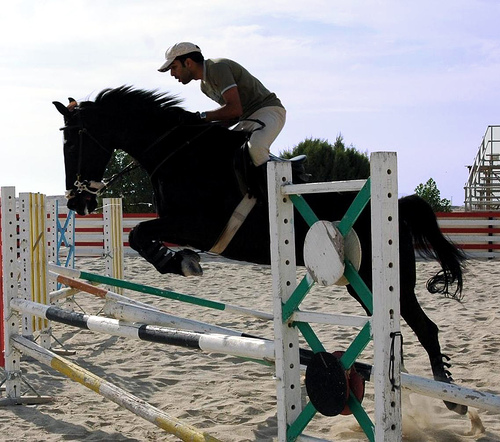

In [6]:
image

In [7]:
def plot_bbox(img, x_min, y_min, x_max, y_max):
    draw_im = img.copy()
    draw = ImageDraw.Draw(draw_im)
    draw.rectangle([(xmin, y_min), (x_max, y_max)], outline='red')
    draw.text((xmin,ymin), 'Hello', anchor="ms")
    # bbox = draw.textbbox((xmin,ymin), 'Hello', anchor="ms")
    # print(bbox)
    return draw_im

In [8]:
label

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

In [9]:
plotted_img = image.copy()
for obj in label['annotation']['object']:
    
    xmin = int(obj['bndbox']['xmin'])
    ymin = int(obj['bndbox']['ymin'])
    xmax = int(obj['bndbox']['xmax'])
    ymax = int(obj['bndbox']['ymax'])

    plotted_img = plot_bbox(plotted_img, xmin, ymin, xmax, ymax)

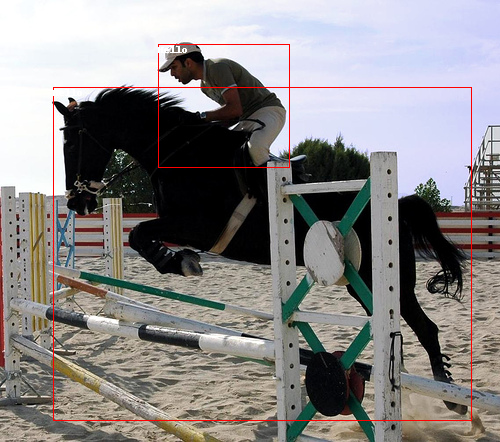

In [10]:
plotted_img

In [27]:
cv_img = transforms.PILToTensor()(image)
cv_img = cv_img.permute((1,2,0)).numpy()

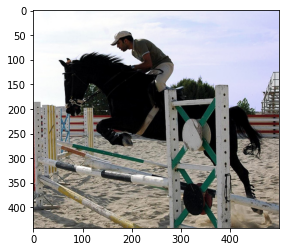

In [28]:
plt.imshow(cv_img)

In [71]:
# Source: https://stackoverflow.com/questions/54843550/edge-box-detection-using-opencv-python
cv_img_drawn = cv_img.copy()
model = './edge_boxes_model/model.yml.gz'

edge_detection = cv.ximgproc.createStructuredEdgeDetection(model)
rgb_im = cv.cvtColor(cv_img_drawn, cv.COLOR_BGR2RGB)
edges = edge_detection.detectEdges(np.float32(rgb_im) / 255.0)

orimap = edge_detection.computeOrientation(edges)
edges = edge_detection.edgesNms(edges, orimap)

edge_boxes = cv.ximgproc.createEdgeBoxes()
edge_boxes.setMaxBoxes(30)
boxes = edge_boxes.getBoundingBoxes(edges, orimap)

for b in boxes[0]:
    x, y, w, h = b
    cv.rectangle(cv_img_drawn, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)

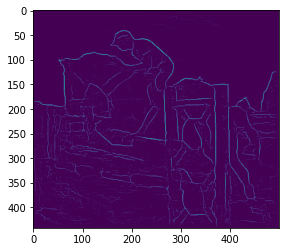

In [30]:
plt.imshow(edges)

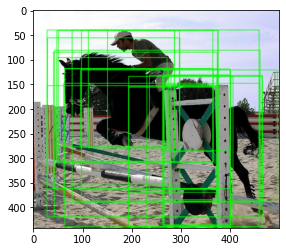

In [32]:
plt.imshow(cv_img_drawn)

In [26]:
def get_iou(bb1, bb2):
    bb1_x1, bb1_y1, bb1_x2, bb1_y2 = bb1
    bb2_x1, bb2_y1, bb2_x2, bb2_y2 = bb2
    assert bb1_x1 < bb1_x2
    assert bb1_y1 < bb1_y2
    assert bb2_x1 < bb2_x2
    assert bb2_y1 < bb2_y2

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1_x1, bb2_x1)
    y_top = max(bb1_y1, bb2_y1)
    x_right = min(bb1_x2, bb2_x2)
    y_bottom = min(bb1_y2, bb2_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
    bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [45]:
cv_img_drawn_2 = cv_img.copy()

gt_boxes = []
for obj in label['annotation']['object']:
    
    xmin = int(obj['bndbox']['xmin'])
    ymin = int(obj['bndbox']['ymin'])
    xmax = int(obj['bndbox']['xmax'])
    ymax = int(obj['bndbox']['ymax'])

    gt_boxes.append([xmin, ymin, xmax, ymax])

active_boxes = []
for bb in boxes[0]:
    x, y, w, h = bb
    bbox = [x, y, x + w, y + h]
    for gt_box in gt_boxes:
        if get_iou(gt_box, bbox) > 0.7:
            active_boxes.append(bbox)

In [46]:
active_boxes

[[43, 81, 461, 419], [79, 40, 459, 387]]

In [50]:
for box in active_boxes:
    cv.rectangle(cv_img_drawn_2, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1, cv.LINE_AA)

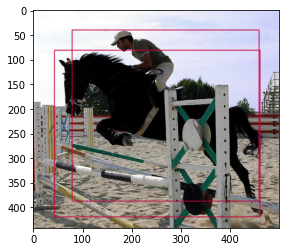

In [51]:
plt.imshow(cv_img_drawn_2)

In [72]:
boxes_per_class = [[] for _ in gt_boxes]
for bb in boxes[0]:
    x, y, w, h = bb
    bbox = [x, y, x + w, y + h]
    for i, gt_box in enumerate(gt_boxes):
        boxes_per_class[i].append((bbox, get_iou(gt_box, bbox)))

In [73]:
for i, class_boxes in enumerate(boxes_per_class):
    boxes_per_class[i] = sorted(class_boxes, key = lambda box_score : box_score[1], reverse=True)

In [79]:
num_boxes = 3
for i, class_boxes in enumerate(boxes_per_class):
    boxes_per_class[i] = []
    for box_score in class_boxes[:num_boxes]:
        boxes_per_class[i].append(box_score[0])

In [80]:
boxes_per_class

[[[43, 81, 461, 419], [79, 40, 459, 387], [64, 119, 400, 438]],
 [[151, 41, 297, 279], [112, 40, 287, 279], [51, 41, 287, 306]]]

In [89]:
cv_img_drawn_2 = cv_img.copy()
for box in gt_boxes:
    cv.rectangle(cv_img_drawn_2, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2, cv.LINE_AA)
for class_boxes in boxes_per_class:
    for box in class_boxes:
        cv.rectangle(cv_img_drawn_2, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1, cv.LINE_AA)

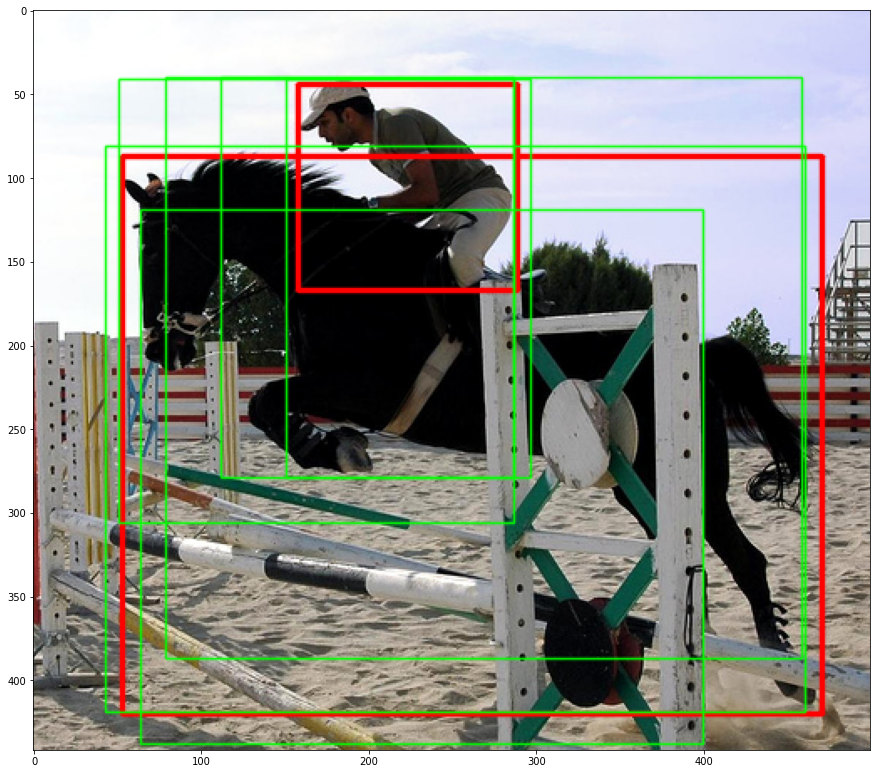

In [90]:
plt.figure(figsize=[15, 20])
plt.imshow(cv_img_drawn_2)